## Exploratory Data Analysis on Interim Data

- Out of good ML principles, we'll only be looking at Arkansas, our training set.


In [1]:
try:
    sc.stop()
except:
    pass
from pyspark import SparkContext
from bigdl.util.common import *


# create sparkcontext with bigdl configuration
sc = SparkContext.getOrCreate(conf=create_spark_conf().setMaster("local[*]"))
from pyspark.sql import SparkSession
spark = SparkSession(sparkContext = sc)
spark.conf.set("spark.sql.session.timeZone", "UTC")

Prepending /home/dyllanjr/anaconda3/envs/solarenv/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path


In [2]:
df = spark.read.csv(f"hdfs://localhost:9000/solar_data/interim/Arkansas_interim.csv", inferSchema=True, header=True)

In [34]:
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [18]:
#For debugging:
print(sns.__version__,'\n',scipy.__version__)

0.8.0 
 1.5.4


In [4]:
df.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Day: integer (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- Minute: integer (nullable = true)
 |-- Cloud Type: integer (nullable = true)
 |-- Dew Point: integer (nullable = true)
 |-- Fill Flag: integer (nullable = true)
 |-- Wind Speed: double (nullable = true)
 |-- Surface Albedo: double (nullable = true)
 |-- Temperature: integer (nullable = true)
 |-- Solar Zenith Angle: double (nullable = true)
 |-- Wind Direction: double (nullable = true)
 |-- GHI: integer (nullable = true)
 |-- timestamp: timestamp (nullable = true)



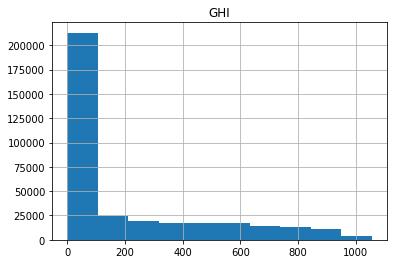

In [27]:
### Let's take a look at our target variable, Global Horizantal Irradiance (GHI)
df.select('GHI').toPandas().hist()
plt.show();

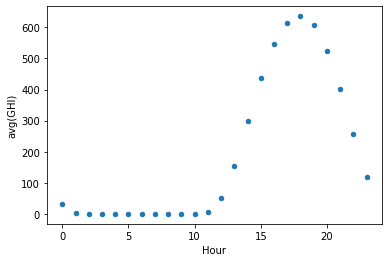

In [26]:
### Let's group by hour to see the day/night cycles
df.groupby('Hour').mean('GHI').toPandas().plot.scatter(x='Hour', y='avg(GHI)')
plt.show();
#Interesting, It doesn't heat up until around 10am, and continues to heat past noon.

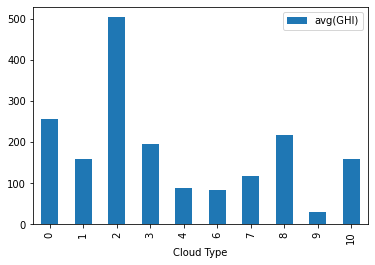

In [29]:
### How do the different cloud types effect GHI?
df.groupby('Cloud Type').mean('GHI').sort('Cloud Type').toPandas().plot.bar(x='Cloud Type', y='avg(GHI)')
plt.show();

##Interestingly, fog seems to amplify the GHI
#Even though the Direct Normal Irradiance (DNI) goes down, the Diffuse Horizontal Irradiance (DIF) likely
#Goes up do to the diffusion of the rays scattering in the low lying fog.
#Whether or not DIF is beneficial for solar panels is up for question given that solar arrays are usually
#set up to capture the Direct Normal Irradiance primarilly.

#GHI = DNI*DIF*cos(solar_zenith)


##Also note that overshooting clouds reduce the GHI the most.
#The Anvil shaped cloud top prevents the DNI contribution 
#And the height of the cloud from the ground prevents a significant diffusion (DIF) contribution

#The cirrus clouds also reduce the GHI more than expected. I would suspect that they reduce GHI less
#due to their thin, wispy nature.

### Cloud Type Meaning:

-15: NaN  
0: Clear   
1: Probably Clear 
2: Fog 
3: Water  
4: Super-Cooled Water 
5: Mixed 
6: Opaque Ice  
7: Cirrus  
8: Overlapping  
9: Overshooting  
10: Unknown 	 
11: Dust  
12: Smoke

In [39]:
from pyspark.sql.types import IntegerType

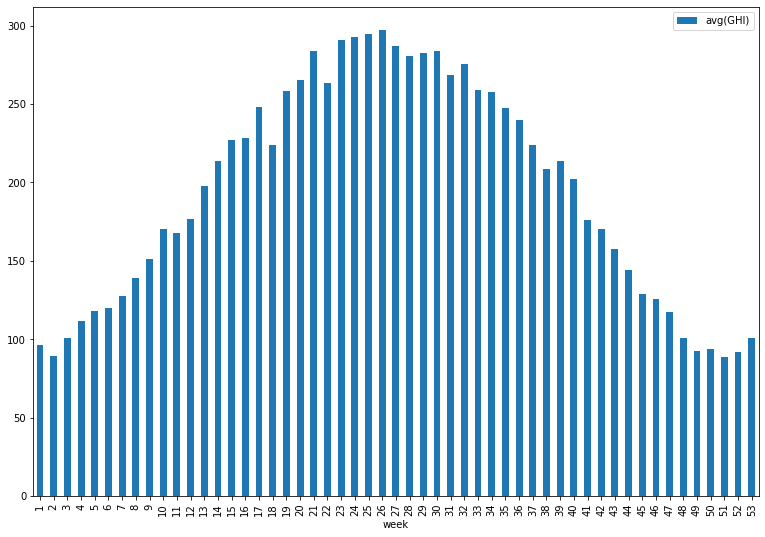

In [43]:
###Let's take a look at seasonal differences by observing the avg GHI by week
from pyspark.sql import functions as F

(df.withColumn('week', F.date_format(F.col('timestamp'), 'w'))
     .withColumn('week', F.col('week').cast(IntegerType()))
    .groupby('week').mean('GHI').sort(F.col('week').asc()).toPandas()
    .plot.bar(x='week', y='avg(GHI)', figsize=(13, 9))
)
plt.show();

##As expected, the highest avg(GHI) corresponds with the summer solstice, marking the longest day of the year
## the lowest avg(GHI) corresponds with the winter solstice, marking the shortest day of the year

<AxesSubplot:>

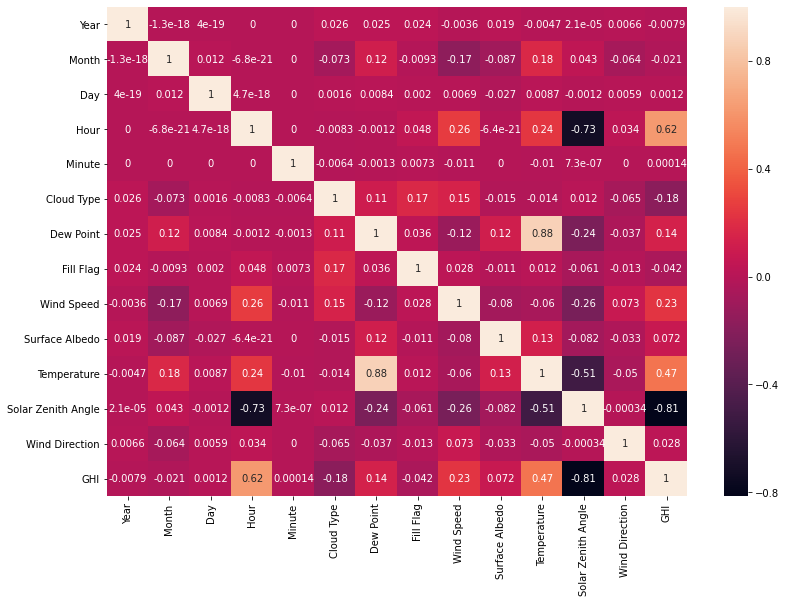

In [44]:
### Correlation Analysis

corrs = df.toPandas().corr()
plt.figure(figsize=(13, 9))
sns.heatmap(corrs, annot=True)

##Dew point and Temperature are potentially multicollinear:
    #this will be a problem for my base linear regression model
    #it may also effect the convergence of my LSTM
    #however MLPs are typically more robust to multicollinearity due to overparameterization
    #will test dropping temp or dewpoint or no columns while training.
    
#some of these features don't make sense to be analysed in this fashion, such as cloud type and fill flag

#The high negative correlation b/t GHI and zenith angle makes sense.
#the larger the zenith angle, the closer to the horizon the sun appears, and thus the more athmosphere the sun's rays
#have to pass through before reaching the surface, increasing scattering and thus decreasing GHI

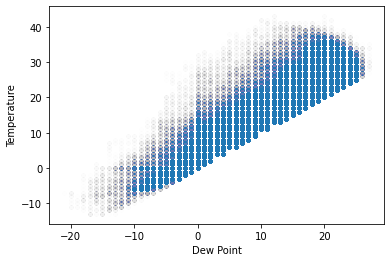

In [50]:
df.select('Dew Point', 'Temperature').toPandas().plot.scatter(x='Dew Point', y='Temperature', alpha=.005)
plt.show();
#Definitely a strong relationship, as temperature increases, dew point increases.